<div>
<h1>Large Language Models Projects</h1>
    <h3>Apply and Implement Strategies for Large Language Models</h3>
    <h2>3.1-Use the Data from your DataFrames with LLMs.</h2>
    
</div>

by [Pere Martra](https://www.linkedin.com/in/pere-martra/)

_______________
Models: dolly-v2-3b / flan-t5-large

Colab Environmet: CPU - High RAM

Keys:
* RAG
* LangChain
* Embeddings
* LCEL
_________________

If you are executing this notebook on Colab you will need a High RAM capacity environment.

If you don't have a Colab Pro acoount you can execute this notebook on kaggle, since you will get more memory from the free tier.

# TUTORIAL HOW TO USE LANGCHAIN AND VECTOR DATABASES TO USE OUR OWN DOCUMENTS WITH HUGGING FACES

In a [previous notebook](https://www.kaggle.com/code/peremartramanonellas/use-a-vectorial-db-to-optimize-prompts-for-llms), we saw how to use a vectorial database to create an enriched prompt for Hugging Face language models. In this one, we incorporate LangChain so that we can make queries to the language model that take into account our information.

The information could be our own documents, or whatever was contained in a business knowledge database.

I have prepared the notebook so that it can work with  different Kaggle datasets, so that it is easy to carry out different tests with different Datasets.

The data has been loaded from a Pandas DataFrame, using the **DataFrameLoader** function from the **document_loaders** library of **LangChain**.


# Install and load the libraries.
To start we need to install the necesary Python packages.
* **[langchain](https://python.langchain.com/docs/get_started/introduction.html)**. The revolutionary framework to build apps using large language models.
* **[sentence_transformers](https://www.sbert.net/)**. necesary to create the embeddings we are going to store in the vector database.  
* **[chromadb](https://www.trychroma.com/)**. This is our vector Database. ChromaDB is easy to use and open source, maybe the most used Vector Database used to store embeddings.

In [2]:
!pip install -q chromadb==0.4.22
!pip install -q langchain==0.1.4
!pip install -q sentence_transformers==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 4.3 MB/s eta 0:00:

# Load the Dataset
As you can see the notebook is ready to work with different Datasets. Just uncomment the lines of the Dataset you want to use.

As we are working in a free and limited space, and we can use just some limited gb of memory I limited the number of news to use with the variable MAX_NEWS.

The name of the field containing the text of the new is stored in the variable *DOCUMENT* and the metadata in *TOPIC*

I used the kotartemiy/topic-labeled-news-dataset https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset

Artem Burgara. (2020). R vs. Python: Topic Labeled News Dataset, . Retrieved December 2023, from https://www.kaggle.com/discussions/general/46091.

But you can ose other datasets, I encourage you to try at least one of these:

https://www.kaggle.com/datasets/gpreda/bbc-news

https://www.kaggle.com/datasets/deepanshudalal09/mit-ai-news-published-till-2023


### Conecting to Kaggle.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q kaggle

In [5]:
import os
#This directory should contain you kaggle.json file with your key
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [6]:
!kaggle datasets download -d kotartemiy/topic-labeled-news-dataset
#!kaggle datasets download -d gpreda/bbc-news

Dataset URL: https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset
License(s): CC0-1.0
 42% 4.00M/9.45M [00:00<00:00, 41.2MB/s]
100% 9.45M/9.45M [00:00<00:00, 56.9MB/s]


In [7]:
import numpy as np
import pandas as pd

In [8]:
import zipfile

# Define the path to your zip file
file_path = '/content/topic-labeled-news-dataset.zip'
#file_path = '/content/bbc-news.zip'

In [9]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [10]:
news = pd.read_csv('/content/drive/MyDrive/kaggle/labelled_newscatcher_dataset.csv', sep=';')
MAX_NEWS = 1000
DOCUMENT="title"
TOPIC="topic"

#news = pd.read_csv('/content/drive/MyDrive/kaggle/bbc_news.csv')
#MAX_NEWS = 500
#DOCUMENT="description"
#TOPIC="title"

#Because it is just a course we select a small portion of News.
subset_news = news.head(MAX_NEWS)

In [11]:
news.head(2)

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en


## CREATE THE DOCUMENT FROM THE DATAFRAME
We are going to load the data from a pandas DataFrame. However, LangChain, through the **document_loader** library, supports multiple data sources, such as Word documents, Excel files, plain text, SQL, and more.

We also imported the Chroma library, which is used to save the embeddings in the ChromaDB database.

In [12]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import Chroma


First, we create the loader, indicating the data source and the name of the column in the DataFrame where we store what we could consider as the document, that is, the information we want to pass to the model so that it takes it into account in its responses.

In [13]:
# creating the loader and specifying the data column
df_loader = DataFrameLoader(subset_news, page_content_column=DOCUMENT)

Then, we use the loader to load the document.

In [14]:
df_document = df_loader.load()

In [15]:
display(df_document[:2])

[Document(page_content="A closer look at water-splitting's solar fuel potential", metadata={'topic': 'SCIENCE', 'link': 'https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php', 'domain': 'eurekalert.org', 'published_date': '2020-08-06 13:59:45', 'lang': 'en'}),
 Document(page_content='An irresistible scent makes locusts swarm, study finds', metadata={'topic': 'SCIENCE', 'link': 'https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw', 'domain': 'pulse.ng', 'published_date': '2020-08-12 15:14:19', 'lang': 'en'})]

# Creating the embeddings
First, we import a couple of libraries.
* CharacterTextSplitter: we will use it to group the information contained in different blocks.
* HuggingFaceEmbeddings: it will create the embeddings in the format that we will store in the database.

In [16]:
from langchain.text_splitter import CharacterTextSplitter
#from langchain.embeddings import HuggingFaceEmbeddings

As I said above we split the data into manageable chunks to store as vectors using **CharacterTextSplitter**. There isn't an exact way to do this, more chunks means more detailed context, but will increase the size of our vectorstore.

There are no magic numbers to inform. It is important to consider that the larger the chunk size, the more context the model will have, but the size of our vector store will also increase.

In [17]:
text_splitter = CharacterTextSplitter(chunk_size=250, chunk_overlap=10)
texts = text_splitter.split_documents(df_document)

In [18]:
display(texts[:5])

[Document(page_content="A closer look at water-splitting's solar fuel potential", metadata={'topic': 'SCIENCE', 'link': 'https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php', 'domain': 'eurekalert.org', 'published_date': '2020-08-06 13:59:45', 'lang': 'en'}),
 Document(page_content='An irresistible scent makes locusts swarm, study finds', metadata={'topic': 'SCIENCE', 'link': 'https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw', 'domain': 'pulse.ng', 'published_date': '2020-08-12 15:14:19', 'lang': 'en'}),
 Document(page_content='Artificial intelligence warning: AI will know us better than we know ourselves', metadata={'topic': 'SCIENCE', 'link': 'https://www.express.co.uk/news/science/1322607/artificial-intelligence-warning-machine-learning-algorithm-social-media-data', 'domain': 'express.co.uk', 'published_date': '2020-08-13 21:01:00', 'lang': 'en'}),
 Document(page_content='Glaciers Could Have Sculpted Mars Valleys: Study', m

We load the library to create the pre trained model from HuggingFace to create the embeddings from sentences.


In [19]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Creating the Index With Chroma
Here we are creating the index of embeddings. Using the document, and the embedding function created above.

In [20]:
directory_cdb = '/content/drive/MyDrive/chromadb'
chroma_db = Chroma.from_documents(
    texts, embedding_function, persist_directory=directory_cdb
)

All the information is in the
vector database, ready to be queried.

## LANGCHAIN

Finally, the time has come to create our chain with LangChain. It will be straightforward. All we do is give it a retriever and a model to call with the result obtained from the retriever.

Now we are going to import RetrievalQA and HuggingFacePipeline classes from langchain module.  

In [21]:
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
#from transformers import pipeline

Now we create the retriever object, the responsible to return the data contained in the ChromaDB Database.

In [22]:
retriever = chroma_db.as_retriever()

I tested the notebook with two models from Fugging Face.

The first one is [dolly-v2-3b](https://huggingface.co/databricks/dolly-v2-3b), the smallest Dolly model. It have 3billion paramaters, more than enough for our sample, and works much better than GPT2. It's a text generation model, and therefore generates slightly more imaginative responses.

The second one is a t5 model. This is a text2text-generation. so it will produce more concise and succinct responses.

Just be sure the test both, and if you want select other models from Hugging Face.

In [23]:
#model_id = "databricks/dolly-v2-3b" #a good textgeneration model for testing
#task="text-generation"

model_id = "google/flan-t5-large" #Nice text2text model
task="text2text-generation"

We use HuggingFacePipeline class to create a pipeline for a specific Hugging Face language model. Let's break down the code:

* **model_id**: This is the ID of the Hugging Face language model you want to use. It typically consists of the model name and version.
* **task**: This parameter specifies the task that you want to perform using the language model. It could be "text-generation", "text2text-generation", "question-answering", or other tasks supported by the model.
* **model_kwargs**: Allows you to provide additional arguments specific to the chosen model. In this case, it sets "temperature" to 0 (indicating deterministic output) and "max_length" to 256, which limits the maximum length of generated text to 256 tokens.
* **pipeline_kwargs**: Allows you to provide extra information related to the pipeline.
  * I’ve specified that the pipeline should return the entire text because that’s what
LangChain needs. In most cases, you won’t encounter any issues by not specifying it,
especially in simple chains like this one. However, there might be some malfunction in
more complex chains where LangChain needs to interpret the entire model response.
  * The other significant value is that I’ve assigned a penalty of 1.1 to model repetition.
This means the model will receive a slight penalty for repeated tokens. This helps
address an issue with some models that tend to repeat parts of the text until reaching the
maximum length assigned to the response.


In [24]:
#If you want to test the  T5 model remove the return_full_text parameter in pipeline_kwargs,
#also I recommend to add model_kwargs and change the temperature.
#    model_kwargs={
#        "temperature": 0,
#        "max_length": 256
#    },
hf_llm = HuggingFacePipeline.from_model_id(
    model_id=model_id,
    task=task,
    model_kwargs={
        "temperature": 0,
        "max_length": 256
    },
    pipeline_kwargs={
        "max_new_tokens": 256,
        "repetition_penalty":1.0,
    },
)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

We are setting up the ***document_qa***, a **RetrievalQA** object, that we are going to use to run the questions.

The ***stuff*** type is the simplest type of chain that we can have. I get the documents from the retiever and use the language model to obtain responses. The other parameters can be:
* stuff: The simplest option; it just takes the documents it deems
appropriate and uses them in the prompt to pass to the model.
* refine: It makes multiple calls to the model with different documents,
trying to obtain a more refined response each time. It may execute a
high number of calls to the model, so it should be used with caution.
* map_reduce: It tries to reduce all the documents into one, possibly
through several iterations. It can compress and collapse the
documents to fit into the prompt sent to the model.
* map_rerank: It calls the model for each document and ranks them,
finally returning the best one. Similar to refine, it can be risky
depending on the number of calls expected.

In [25]:
document_qa = RetrievalQA.from_chain_type(
    llm=hf_llm, retriever=retriever, chain_type='stuff'
)

Time to call the chain and obtain the responses!

In [26]:
#Sample question for newscatcher dataset.
response = document_qa.invoke("Can I buy a Toshiba laptop?")

#Sample question for BBC Dataset.
#response = document_qa.run("Who is going to meet boris johnson?")
display(response)

{'query': 'Can I buy a Toshiba laptop?', 'result': 'no'}

### Using the new LCEL Architecture from LangChain.
LangChain recommends using LCEL (LangChain Expression Language) over Chains. I'm using both methods in the notebook, but please note that LCEL is the recommended approach.
* ChatPromptTemplate: Actually, this library has nothing to do with
LCEL. I’m going to use it to create a prompt template, and thus
format the prompt we’ll pass to the model a bit better.
* RunnablePassThrough: It does nothing more than take an input
and pass it directly. It’s necessary because when invoking the chain
that is going to be created, we will pass the user’s question to it. It will
simply take the input and pass it to the next element in the chain.
* StrOuputParser: Formats the model response.

In [27]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """Answer the question based on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

The first thing it does is take the input it will receive as a parameter and assigns it to
the variable question, then executes the retriever, saving the result in context.

With the values of context and question, the prompt template is constructed and
sent to the model.

Finally, the model’s response goes through StrOutputParser and is then received by
the user.
Now we have a chain ready to be called

In [28]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | hf_llm
    | StrOutputParser()
)

In [29]:
chain.invoke("Can I buy a Toshiba laptop?")

Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors


'no'

## Checking the cosine distance between sentences.

Bonus section: As you may know, vector databases find the most relevant information to a user's question by measuring the distance between embeddings.

Here's a brief example to illustrate how this works.

In [ ]:
embedding_s1 = embedding_function.embed_query(
    "I would like to eat more vegetables and exercise every day")

embedding_s2 = embedding_function.embed_query(
    "I will try to maintain a healthier lifestyle.")

embedding_s3 = embedding_function.embed_query(
    "I prefer to play football")



All the embeddings have the same lenght despite the sentence length.

In [ ]:
print(f""" embedding_s1 = {len(embedding_s1)}
 embedding_s2 =  {len(embedding_s2)}
 embedding_s3 =  {len(embedding_s3)}""")

 embedding_s1 = 384
 embedding_s2 =  384
 embedding_s3 =  384


In [ ]:
# 5 first positions of embedding_s1.
print(embedding_s1[:5])
print(embedding_s2[:5])
print(embedding_s3[:5])

[-0.034526657313108444, 0.031680285930633545, -0.03841095045208931, 0.07523446530103683, -0.04117880389094353]
[-0.009032496251165867, 0.014947249554097652, 0.06308788061141968, 0.06641353666782379, 0.03385470062494278]
[0.01728087104856968, -0.019022813066840172, 0.011131912469863892, -0.003836166812106967, 0.03133479878306389]


Importing SKLEARN to measure the cosine distances

In [ ]:
!pip install -q scikit-learn==1.2.2

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
embedding_s1_2d = np.array(embedding_s1).reshape(1, -1)
embedding_s2_2d = np.array(embedding_s2).reshape(1, -1)
embedding_s3_2d = np.array(embedding_s3).reshape(1, -1)

In [ ]:
print(embedding_s1_2d[0][:5])

[-0.03452671  0.03168032 -0.03841094  0.07523444 -0.04117881]


S1 sentence is more similar to S2 sentence than to S3 sentence. That is because the first sentences are talking about a healthier way of live.

In [ ]:
print(cosine_similarity(embedding_s1_2d, embedding_s2_2d))
print(cosine_similarity(embedding_s1_2d, embedding_s3_2d))
print(cosine_similarity(embedding_s2_2d, embedding_s3_2d))


[[0.54180279]]
[[0.16314688]]
[[0.25131365]]


## Print embeddings

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2)

In [ ]:
embeddings_sentences=[]
embeddings_sentences.append(embedding_s1)
embeddings_sentences.append(embedding_s2)
embeddings_sentences.append(embedding_s3)
PCA_model.fit(embeddings_sentences)
embeddings_coord = PCA_model.transform(embeddings_sentences)

In [ ]:
print(embeddings_coord)

[[-0.46251847 -0.44190478]
 [-0.31148544  0.50339061]
 [ 0.77400391 -0.06148583]]


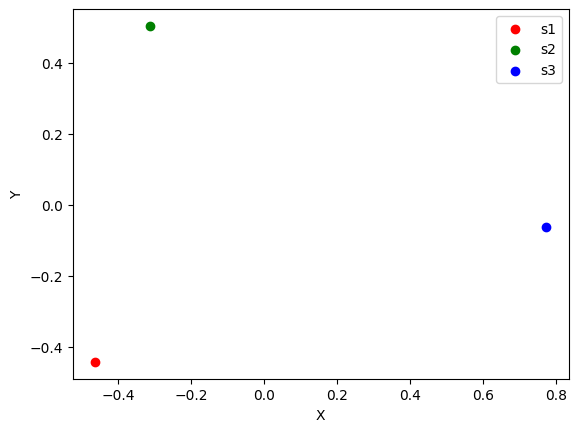

In [ ]:
import matplotlib.pyplot as plt

x, y = zip(*embeddings_coord)

# Name the points
names = ['s1', 's2', 's3']
# Colors
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    plt.scatter(x[i], y[i], marker='o', color=colors[i], label=name)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# Conclusions.
Not a long notebook, but with a lot of content.

We have used a vectorial database to store the information from a Kaggle dataset. We have incorporated it into a LangChain chain through a retriever, and now we are able to make queries about the information contained in the dataset to a couple of Hugging Face Language Models.

And Also you've been introduce to LCEL!!!

Please don't stop here.

* The notebook is prepared to use two Datasets. Do tests with it.An if you have time select other Datset from Kaggle.

* Find another model on Hugging Face and compare it.

* We loaded the data from a Dataframe, try to upload Data from a .txt file.



